# Text Classification in Cross-Validation using Long Short-Term Memory

## Import Libraries

In [1]:
import re
import time
import torch
import random
import numpy as np
import unicodedata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from lime import lime_text
from torch import nn, optim
from sklearn import metrics
from string import punctuation
from sklearn import preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

## Set Hyparameters

### Dataset Language Setting

In [2]:
language="italian"

language_w="../input/fasttext-aligned-word-vectors/wiki.it.align.vec"

### Model Parameters

In [3]:
batch_size = 128
dropout_pc = 0.5
n_epochs = 100
patience=5
hidden_dim=50
lr = 1e-3
num_layers=1
bidirectional=True

nfold=10

### Dataset Parameters

In [4]:
path_db="../input/ciao9cci/politica.xlsx"
df = pd.read_excel(path_db, sheet_name="Foglio1")

text="testo"
review="cap_maj_master"

n_top_class=35

## Enable GPU

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 2019
#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

## Load Dataset

In [6]:
top_class=df.groupby(review).count()[[text]]
top_class=top_class.sort_values(by=[text], ascending=False).head(n_top_class)
top_class=top_class.apply(list).reset_index()
top_class = [d for d in top_class[review]]
print(top_class)

df=df.loc[df[review].isin(top_class)]
print(f'Found {len(df)} texts.')
print(f'{df[review].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df[review])]

df = df[df[text].str.split().str.len().gt(5)]

print(f'{df[text].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df[text])]

le = preprocessing.LabelEncoder()
le.fit(df[review])
df[review]=le.transform(df[review])
classes = [int(c) for c in df[review].values]
documents = [d for d in df[text]]

output_dim = len(np.unique(classes))

[12.0, 10.0, 20.0, 1.0, 3.0, 15.0, 5.0, 6.0, 7.0, 19.0, 4.0, 9.0, 2.0, 16.0, 21.0, 8.0, 13.0, 17.0, 14.0, 23.0, 18.0]
Found 5672 texts.
0 document(s) with no classification removed
0 document(s) with no text removed


## Class Distribution Diagram

Number of Classes found:  21


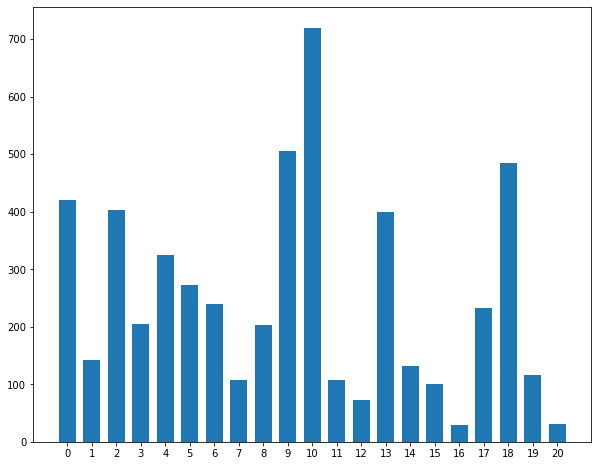

In [7]:
y = np.bincount(classes)
x = np.arange(len(y))
print("Number of Classes found: ", len(y))
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x, y,width=0.7)
ax.set_xticks(x)
ax.set_aspect('auto')
plt.show()


## Define Preprocessor

In [8]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    #text = re.sub(r'[^\w\s]'," ", text)
    text=re.sub('\d+',' ',str(text))
    text=re.sub('[ﾫﾻ]','',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower().strip()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text

def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

stop=set(stopwords.words(language))

def tokenizer(text):
    stop=set(stopwords.words(language))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    filtered_sentence = [w for w in filtered_sentence if len(w)>3]
    return filtered_sentence
    
def split_words_documents(documents):
    tokenized = documents = [tokenizer(strip_accents(preprocessor(document))) 
                              for document in documents]
    all_text = []
    for tokens in tokenized:
        for t in tokens:
            all_text.append(t)
    return tokenized, set(all_text)

In [9]:
documents, vocab = split_words_documents(documents)

## Preprocessed Dataset Statistics

In [10]:
print("Max sequence length: ", np.max([len(x) for x in documents]))
print("Average sequence length: ",np.mean([len(x) for x in documents]))
quant=np.quantile([len(x) for x in documents],.75)
hidden_dim=int(quant)
print("Quantile sequence length: ",quant)

Max sequence length:  1375
Average sequence length:  201.02611015818562
Quantile sequence length:  248.0


## Vocabulary Build

In [11]:
vocaboli=set(line.strip() for line in open('../input/prova2/prova.txt'))
vocaboli_more=vocaboli.union(vocab)
print("Aggiunte ",len(vocaboli_more)-len(vocaboli),"/",len(vocab)," parole")

Aggiunte  14648 / 49263  parole


In [12]:
def create_dictionaries(words):
    word_to_int_dict = {w:i+1 for i,w in enumerate(words)}
    int_to_word_dict = {i:w for w,i in word_to_int_dict.items()}
    return word_to_int_dict, int_to_word_dict
word_to_int_dict, int_to_word_dict = create_dictionaries(vocaboli)

## Define Padding

In [13]:
def pad_text(tokenized_documents,seq_length):
    documents = []
    length=[]
    for document in tokenized_documents:
        if len(document) >= seq_length:
            documents.append(document[:seq_length])
            length.append(seq_length)
        else:
            length.append(len(document))
            documents.append(document+['']*(seq_length-len(document)))
    return np.array(documents),np.array(length)


In [14]:
int_to_word_dict[0]=''
word_to_int_dict['']=0

## Pretrained Vector Loader

In [15]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.double)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [16]:
# Load pretrained vectors
print("Tokenizing...\n")
embeddings = load_pretrained_vectors(word_to_int_dict, language_w)
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


871053it [00:46, 18892.68it/s]


There are 135327 / 279895 pretrained vectors found.


## Utility Functions

In [17]:
def sort_batch(X,lengths,y):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X,lengths, y 

### DataLoader Function

In [18]:
def create_data_loader(train_c,train_len, valid_c, valid_len, train_l,valid_l,batch_size):
    x_train = torch.tensor(train_c, dtype=torch.long,device=DEVICE)
    x_train_len = torch.tensor(train_len, dtype=torch.long,device=DEVICE)
    y_train = torch.tensor(train_l, dtype=torch.long, device=DEVICE)
    x_cv = torch.tensor(valid_c, dtype=torch.long, device=DEVICE)
    x_cv_len = torch.tensor(valid_len, dtype=torch.long, device=DEVICE)
    y_cv = torch.tensor(valid_l, dtype=torch.long, device=DEVICE)
    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train,x_train_len, y_train)
    valid = torch.utils.data.TensorDataset(x_cv,x_cv_len, y_cv)
    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader
    

### Plot Function

In [19]:
def plot_graph(train_loss, valid_loss):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    #plt.ylim(0, 0.5) # consistent scale
    #plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### EarlyStopping Function

In [20]:
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Define Model

In [21]:
class ClassificationRNN(nn.Module):
    
    def __init__(self, 
                 pretrained_embedding=None,
                freeze_embedding=False,
                 n_vocab=None,
                 hidden_dim=100,
                 output_dim=13,
                 dropout = 0.8,
                 pad_idx=0.0,
                 num_layers=2,
                bidirectional=True):
        super().__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.n_vocab, self.n_embed = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        
        
         
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(self.n_embed, 
                           hidden_dim,
                           num_layers=num_layers,
                          bidirectional=bidirectional,
                          dropout=0 if num_layers < 2 else dropout,
                          batch_first=True)
        self.fc1 = nn.Linear(hidden_dim * 4 if bidirectional else hidden_dim*2,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        

        
        
    def forward(self, text, text_length):
        h_embedding = self.dropout(self.embedding(text))
        #packed = torch.nn.utils.rnn.pack_padded_sequence(h_embedding, text_length,batch_first=True, enforce_sorted=False)
        h_lstm, (h,c) = self.rnn(h_embedding)
        #h_lstm, output_lengths = nn.utils.rnn.pad_packed_sequence(h_lstm,batch_first=True)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        
        out=self.fc1(conc)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

## Evaluate Function

In [22]:
def evaluate(model, data_loader, criterion):
    model.eval()
    val_accuracy = []
    val_loss = []
    with torch.no_grad():
        for i, (x_batch,len_batch, y_batch) in enumerate(data_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            logits= model(x_batch,len_batch)
            loss = criterion(logits, y_batch)
            val_loss.append(loss.item())
            
            _, preds = torch.max(logits, 1)
            accuracy = (preds == y_batch).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

## Define Train Function

In [23]:
def train(model, optimizer,criterion, train_loader, val_loader=None, patience=7, epochs=10):
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)
    best_accuracy=0
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        t0_epoch = time.time()
        total_loss = 0
        ###################
        # train the model #
        ###################
        model.train()
        for i, (x_batch,len_batch, y_batch) in enumerate(train_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            y_pred= model(x_batch,len_batch)
            # calculate the loss
            loss = criterion(y_pred, y_batch)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        ######################    
        # validate the model #
        ###################### 
        valid_losses, val_accuracy = evaluate(model, val_loader,criterion)
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        time_elapsed = time.time() - t0_epoch
        print(f"{epoch :^7} | {train_loss:^12.6f} | {valid_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        
    print("\n")
    
    plot_graph(avg_train_losses, avg_valid_losses)
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model
    

## Define Predict Function

In [24]:
def pytorch_predict(model, test_loader):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    labels=[]
    with torch.no_grad():
        for (text,length, label) in test_loader: 
            #text,length, label=sort_batch(text,length, label)
            outputs = model(text,length)
            _, preds = torch.max(outputs, 1)
            for pred in preds:
                labels.append(pred.item())
    
    return labels

In [26]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Cross-Validation Loop

train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  366.731102  | 294.325260 |   11.25   |   5.36   
Validation loss decreased (inf --> 294.325260).  Saving model ...
   2    |  354.243307  | 284.448508 |   11.72   |   5.36   
Validation loss decreased (294.325260 --> 284.448508).  Saving model ...
   3    |  321.008826  | 249.351032 |   21.09   |   5.37   
Validation loss decreased (284.448508 --> 249.351032).  Saving model ...
   4    |  276.828772  | 229.668045 |   33.50   |   5.45   
Validation loss decreased (249.351032 --> 229.668045).  Saving model ...
   5    |  223.902627  | 206.347672 |   35.13   |   5.45   
Validation loss decreased (229.668045 --> 206.347672).  Saving model ...
   6    |  180.174969  | 192.084689 |   44.75   |   5.34   
Validation loss decreased (206.347672 --> 192.084689).  Saving model ...


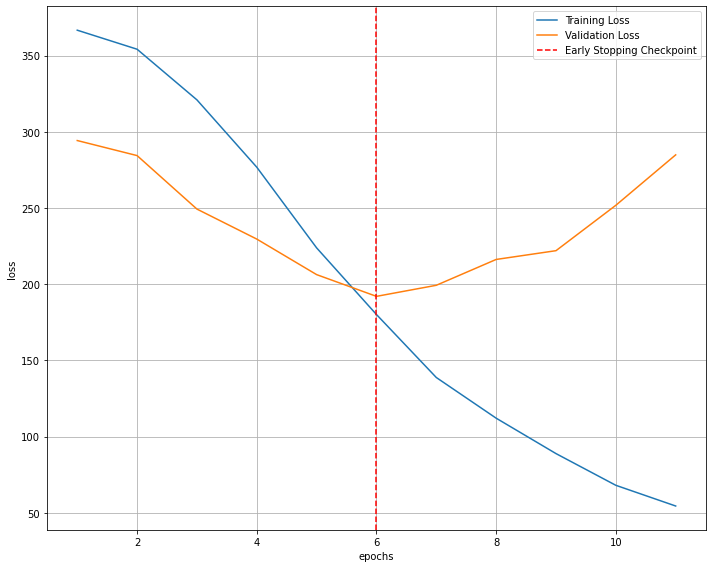

--------------- Fold:  1 ---------------------

              precision    recall  f1-score   support

           0       0.37      0.57      0.45        42
           1       0.50      0.07      0.12        15
           2       0.83      0.75      0.79        40
           3       0.40      0.67      0.50        21
           4       0.53      0.62      0.57        32
           5       0.70      0.78      0.74        27
           6       0.44      0.58      0.50        24
           7       0.00      0.00      0.00        11
           8       0.27      0.35      0.30        20
           9       0.82      0.80      0.81        50
          10       0.61      0.58      0.60        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.22      0.28      0.24        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

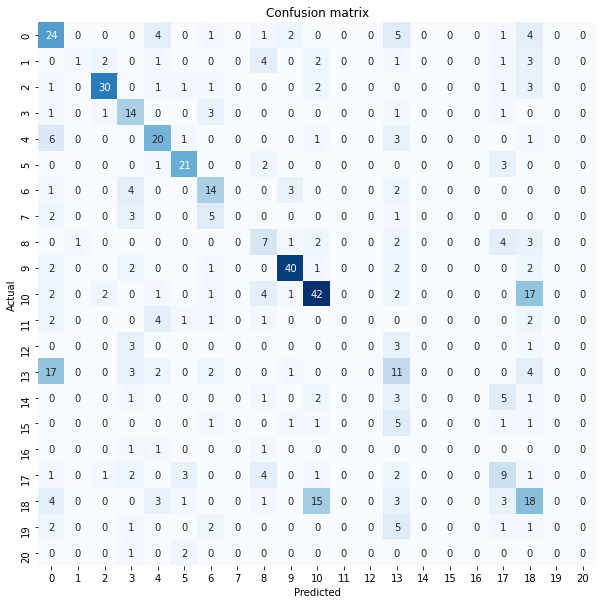


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  364.680220  | 293.764485 |   11.25   |   5.59   
Validation loss decreased (inf --> 293.764485).  Saving model ...
   2    |  351.410794  | 282.449317 |   16.56   |   5.36   
Validation loss decreased (293.764485 --> 282.449317).  Saving model ...
   3    |  318.837238  | 253.112680 |   21.41   |   5.39   
Validation loss decreased (282.449317 --> 253.112680).  Saving model ...
   4    |  273.779260  | 228.933922 |   30.94   |   5.36   
Validation loss decreased (253.112680 --> 228.933922).  Saving model ...
   5    |  222.519114  | 213.727548 |   38.52   |   5.38   
Validation loss decreased (228.933922 --> 213.727548).  Saving model ...
   6    |  172.513914  | 214.856612 |   43.79   |   5.40   
EarlyStopping counter: 1 out of 5
   7    |  133.509595  | 221.879475 | 

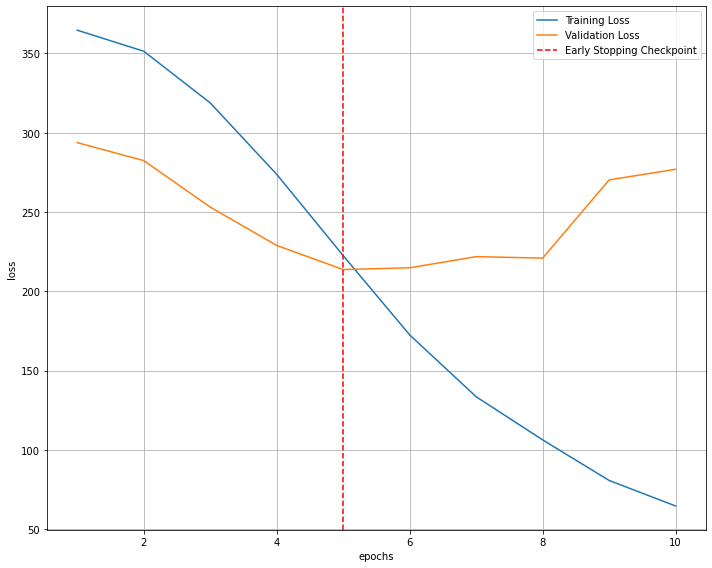

--------------- Fold:  2 ---------------------

              precision    recall  f1-score   support

           0       0.35      0.43      0.39        42
           1       0.00      0.00      0.00        15
           2       0.39      0.75      0.52        40
           3       0.26      0.35      0.30        20
           4       0.39      0.27      0.32        33
           5       0.63      0.61      0.62        28
           6       0.38      0.62      0.48        24
           7       0.00      0.00      0.00        11
           8       0.08      0.10      0.09        20
           9       0.81      0.78      0.80        50
          10       0.60      0.82      0.69        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.30      0.07      0.12        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

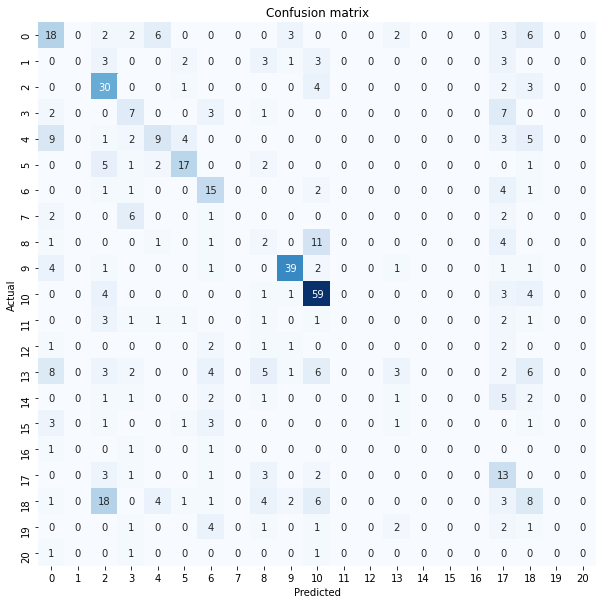


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  366.322200  | 293.220664 |   11.25   |   5.44   
Validation loss decreased (inf --> 293.220664).  Saving model ...
   2    |  350.436478  | 277.283731 |   13.59   |   5.36   
Validation loss decreased (293.220664 --> 277.283731).  Saving model ...
   3    |  319.038964  | 257.650034 |   19.06   |   5.38   
Validation loss decreased (277.283731 --> 257.650034).  Saving model ...
   4    |  267.072859  | 231.664852 |   28.10   |   5.37   
Validation loss decreased (257.650034 --> 231.664852).  Saving model ...
   5    |  219.993878  | 229.381195 |   31.69   |   5.36   
Validation loss decreased (231.664852 --> 229.381195).  Saving model ...
   6    |  177.802590  | 214.405092 |   37.76   |   5.41   
Validation loss decreased (229.381195 --> 214.405092).  Saving model ...

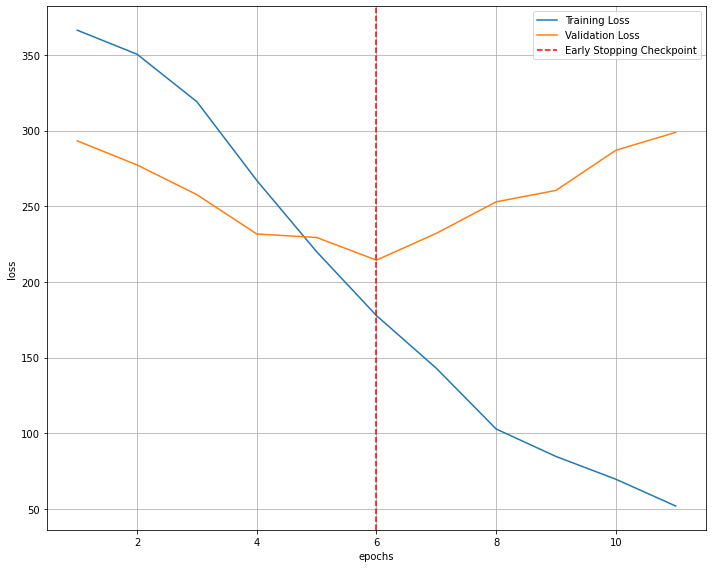

--------------- Fold:  3 ---------------------

              precision    recall  f1-score   support

           0       0.36      0.81      0.50        42
           1       0.25      0.07      0.11        14
           2       0.67      0.45      0.54        40
           3       0.25      0.55      0.34        20
           4       0.44      0.55      0.49        33
           5       0.46      0.68      0.55        28
           6       0.40      0.25      0.31        24
           7       0.00      0.00      0.00        11
           8       0.33      0.35      0.34        20
           9       0.81      0.68      0.74        50
          10       0.70      0.72      0.71        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.12      0.10      0.11        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

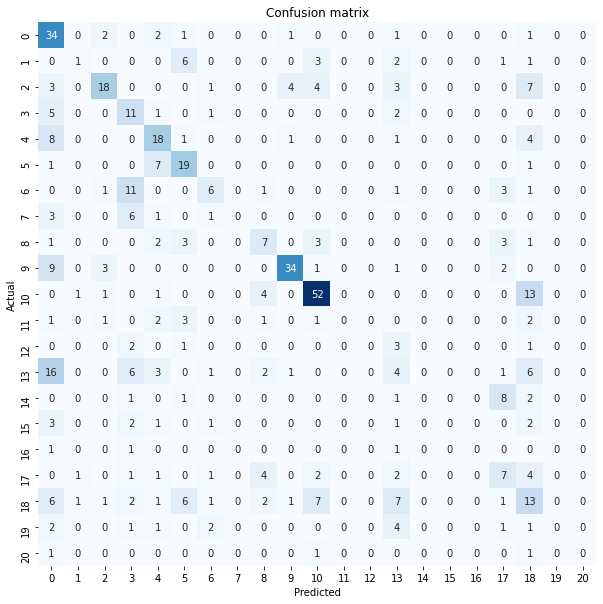


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  366.621490  | 292.790388 |   11.25   |   5.59   
Validation loss decreased (inf --> 292.790388).  Saving model ...
   2    |  352.042116  | 286.164270 |   13.28   |   5.40   
Validation loss decreased (292.790388 --> 286.164270).  Saving model ...
   3    |  331.005230  | 265.723216 |   16.41   |   5.40   
Validation loss decreased (286.164270 --> 265.723216).  Saving model ...
   4    |  291.865897  | 227.797284 |   28.12   |   5.36   
Validation loss decreased (265.723216 --> 227.797284).  Saving model ...
   5    |  242.876145  | 209.796432 |   36.51   |   5.37   
Validation loss decreased (227.797284 --> 209.796432).  Saving model ...
   6    |  195.969820  | 200.733703 |   41.78   |   5.39   
Validation loss decreased (209.796432 --> 200.733703).  Saving model ...

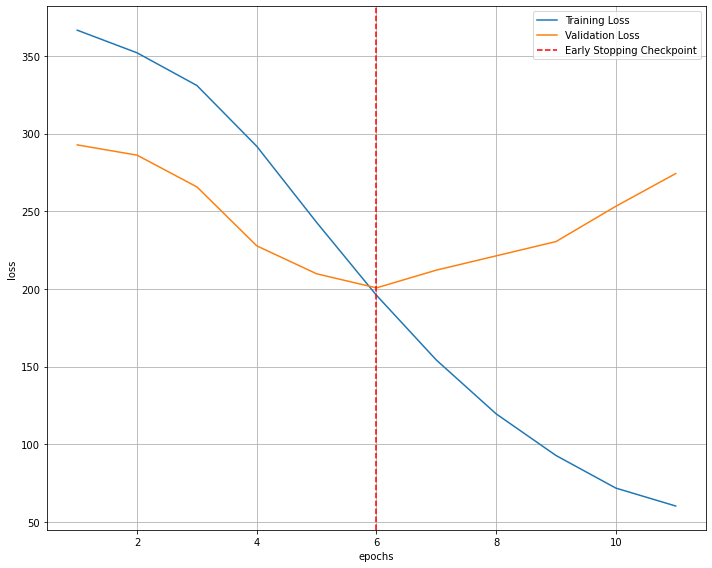

--------------- Fold:  4 ---------------------

              precision    recall  f1-score   support

           0       0.40      0.19      0.26        42
           1       0.00      0.00      0.00        14
           2       0.47      0.78      0.58        40
           3       0.26      0.55      0.35        20
           4       0.33      0.45      0.38        33
           5       0.55      0.86      0.67        28
           6       0.24      0.52      0.33        23
           7       0.00      0.00      0.00        11
           8       0.27      0.20      0.23        20
           9       0.78      0.78      0.78        50
          10       0.64      0.74      0.68        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.30      0.17      0.22        40
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        10
          16       0.00      0.00

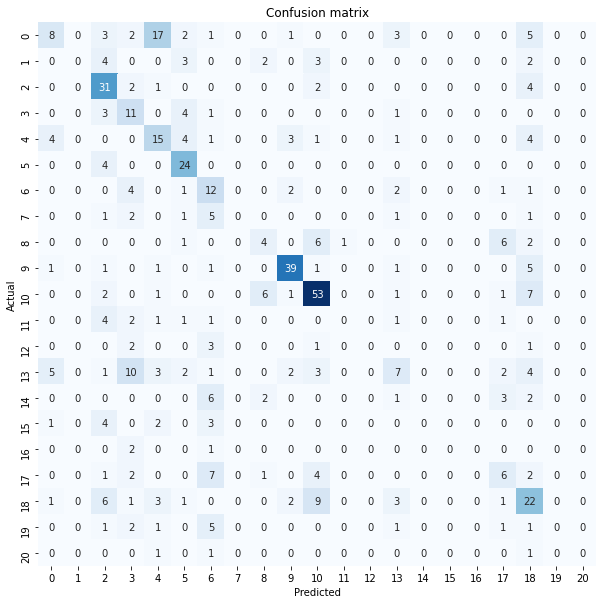


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  366.584079  | 292.505884 |   11.25   |   5.38   
Validation loss decreased (inf --> 292.505884).  Saving model ...
   2    |  351.816054  | 286.537807 |   11.41   |   5.38   
Validation loss decreased (292.505884 --> 286.537807).  Saving model ...
   3    |  323.269837  | 249.691075 |   25.47   |   5.37   
Validation loss decreased (286.537807 --> 249.691075).  Saving model ...
   4    |  275.335260  | 217.983462 |   34.35   |   5.36   
Validation loss decreased (249.691075 --> 217.983462).  Saving model ...
   5    |  218.447828  | 196.022026 |   42.09   |   5.37   
Validation loss decreased (217.983462 --> 196.022026).  Saving model ...
   6    |  167.153884  | 202.527165 |   44.62   |   5.36   
EarlyStopping counter: 1 out of 5
   7    |  125.666879  | 209.781512 | 

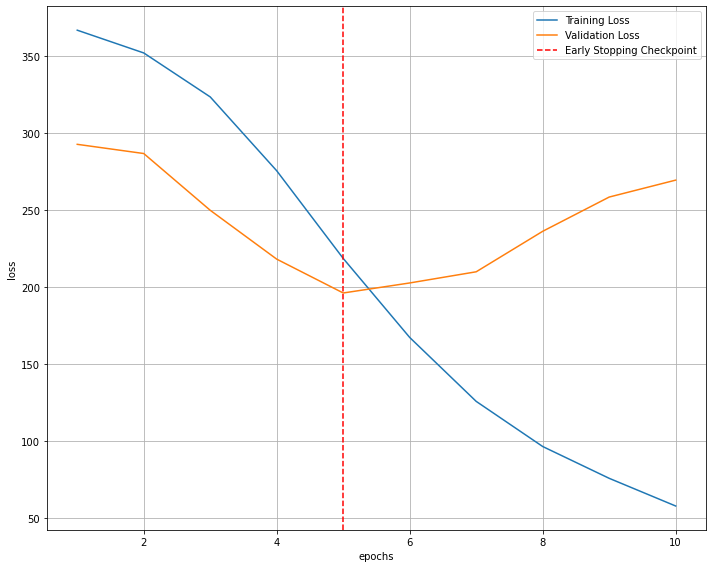

--------------- Fold:  5 ---------------------

              precision    recall  f1-score   support

           0       0.51      0.50      0.51        42
           1       0.50      0.14      0.22        14
           2       0.59      0.33      0.42        40
           3       0.38      0.60      0.46        20
           4       0.71      0.15      0.25        33
           5       0.62      0.85      0.72        27
           6       0.29      0.62      0.39        24
           7       0.00      0.00      0.00        11
           8       0.14      0.10      0.12        20
           9       0.76      0.82      0.79        51
          10       0.66      0.79      0.72        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.20      0.30      0.24        40
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        10
          16       0.00      0.00

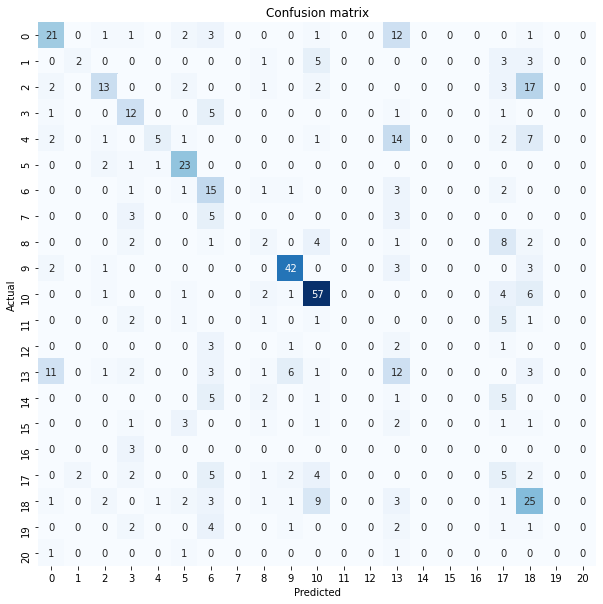


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  365.502157  | 293.104819 |   11.25   |   5.58   
Validation loss decreased (inf --> 293.104819).  Saving model ...
   2    |  351.608014  | 280.398501 |   15.00   |   5.38   
Validation loss decreased (293.104819 --> 280.398501).  Saving model ...
   3    |  319.830549  | 246.645135 |   25.00   |   5.37   
Validation loss decreased (280.398501 --> 246.645135).  Saving model ...
   4    |  270.974976  | 227.763921 |   26.88   |   5.38   
Validation loss decreased (246.645135 --> 227.763921).  Saving model ...
   5    |  221.459330  | 194.282220 |   44.72   |   5.55   
Validation loss decreased (227.763921 --> 194.282220).  Saving model ...
   6    |  170.770420  | 197.638342 |   47.80   |   5.39   
EarlyStopping counter: 1 out of 5
   7    |  128.019801  | 216.637654 | 

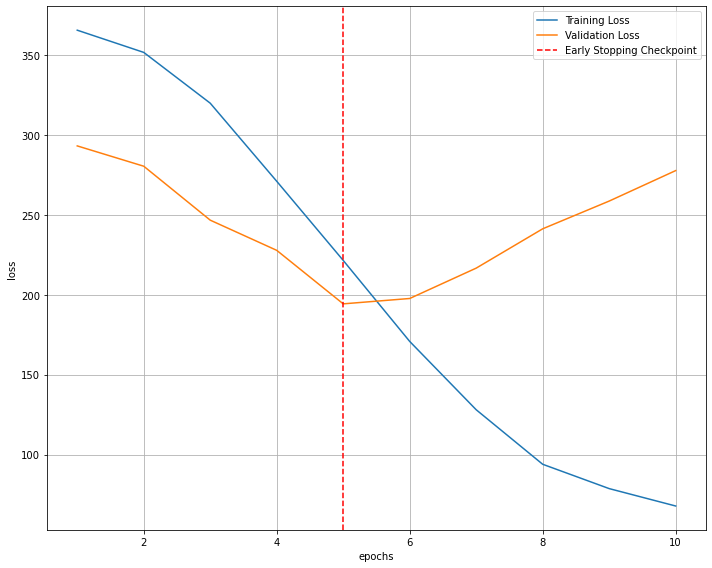

--------------- Fold:  6 ---------------------

              precision    recall  f1-score   support

           0       0.49      0.50      0.49        42
           1       0.00      0.00      0.00        14
           2       0.52      0.73      0.61        41
           3       0.41      0.35      0.38        20
           4       0.48      0.50      0.49        32
           5       0.43      0.81      0.56        27
           6       0.28      0.54      0.37        24
           7       0.20      0.09      0.13        11
           8       1.00      0.10      0.17        21
           9       0.63      0.84      0.72        51
          10       0.71      0.79      0.75        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.19      0.26      0.22        39
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        11
          16       0.00      0.00

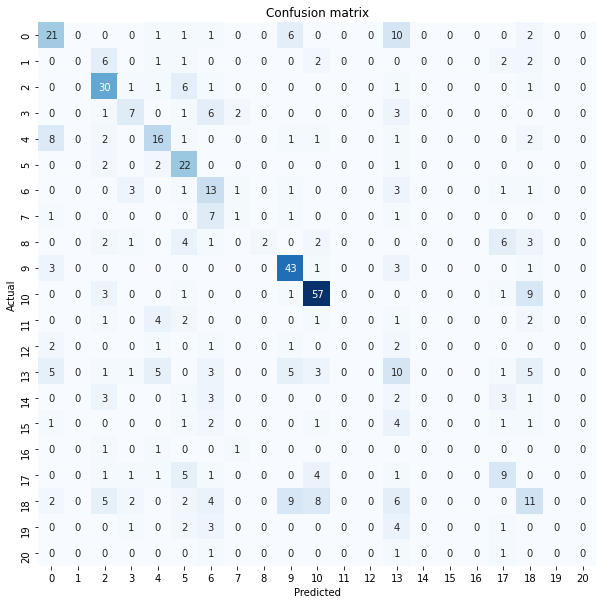


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  365.001517  | 292.664329 |   11.25   |   5.36   
Validation loss decreased (inf --> 292.664329).  Saving model ...
   2    |  353.645522  | 274.216958 |   13.28   |   5.37   
Validation loss decreased (292.664329 --> 274.216958).  Saving model ...
   3    |  322.430665  | 245.604170 |   24.06   |   5.42   
Validation loss decreased (274.216958 --> 245.604170).  Saving model ...
   4    |  276.676029  | 213.296388 |   33.83   |   5.38   
Validation loss decreased (245.604170 --> 213.296388).  Saving model ...
   5    |  227.871805  | 195.649486 |   44.36   |   5.37   
Validation loss decreased (213.296388 --> 195.649486).  Saving model ...
   6    |  180.763370  | 187.575266 |   48.89   |   5.37   
Validation loss decreased (195.649486 --> 187.575266).  Saving model ...

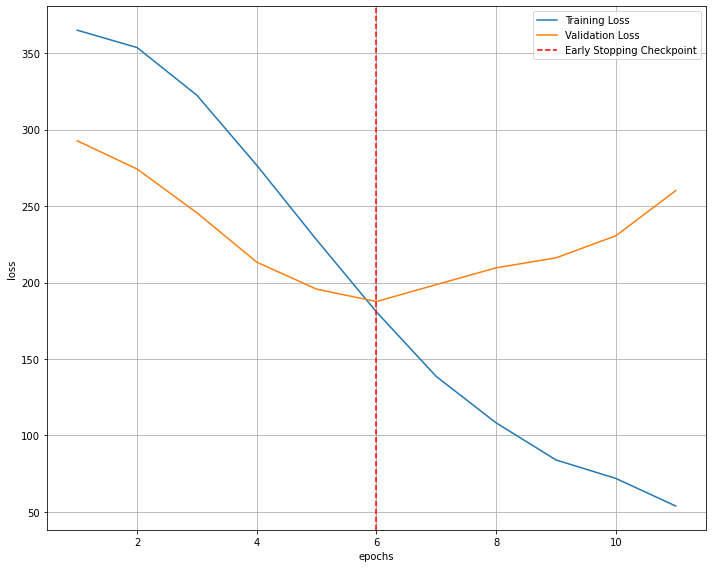

--------------- Fold:  7 ---------------------

              precision    recall  f1-score   support

           0       0.35      0.38      0.36        42
           1       0.10      0.14      0.12        14
           2       0.84      0.88      0.86        41
           3       0.62      0.24      0.34        21
           4       0.36      0.47      0.41        32
           5       0.43      0.78      0.55        27
           6       0.40      0.79      0.54        24
           7       0.00      0.00      0.00        10
           8       0.50      0.24      0.32        21
           9       0.93      0.73      0.81        51
          10       0.71      0.85      0.77        72
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         8
          13       0.14      0.20      0.16        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

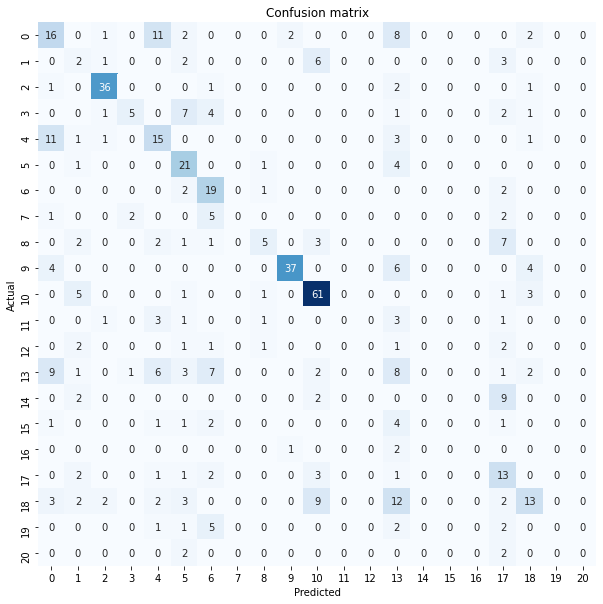


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  366.041015  | 292.808365 |   11.25   |   5.59   
Validation loss decreased (inf --> 292.808365).  Saving model ...
   2    |  352.241871  | 280.230119 |   18.28   |   5.37   
Validation loss decreased (292.808365 --> 280.230119).  Saving model ...
   3    |  320.155300  | 248.327596 |   25.47   |   5.36   
Validation loss decreased (280.230119 --> 248.327596).  Saving model ...
   4    |  269.845628  | 219.541293 |   36.15   |   5.37   
Validation loss decreased (248.327596 --> 219.541293).  Saving model ...
   5    |  209.190646  | 205.521389 |   39.43   |   5.40   
Validation loss decreased (219.541293 --> 205.521389).  Saving model ...
   6    |  167.310802  | 210.185795 |   37.86   |   5.40   
EarlyStopping counter: 1 out of 5
   7    |  126.084748  | 232.936984 | 

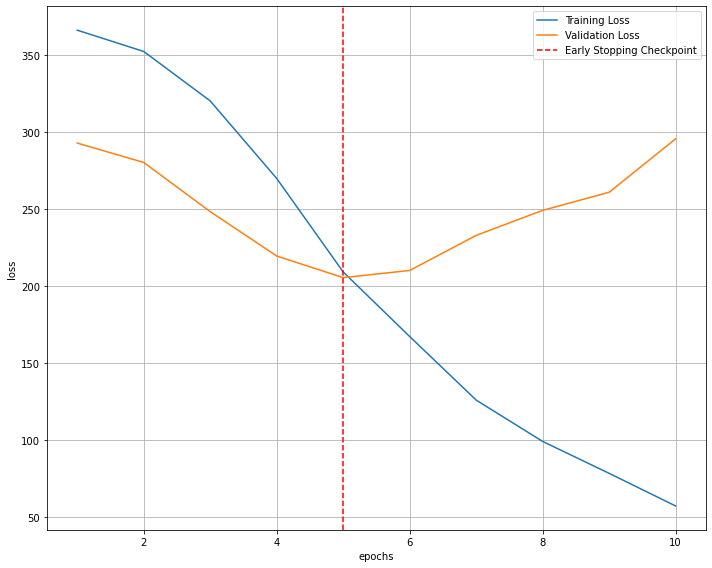

--------------- Fold:  8 ---------------------

              precision    recall  f1-score   support

           0       0.73      0.26      0.39        42
           1       0.00      0.00      0.00        14
           2       0.64      0.85      0.73        41
           3       0.00      0.00      0.00        21
           4       0.51      0.59      0.55        32
           5       0.68      0.78      0.72        27
           6       0.27      0.33      0.30        24
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        21
           9       0.62      0.84      0.72        51
          10       0.66      0.85      0.74        72
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         8
          13       0.11      0.17      0.13        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

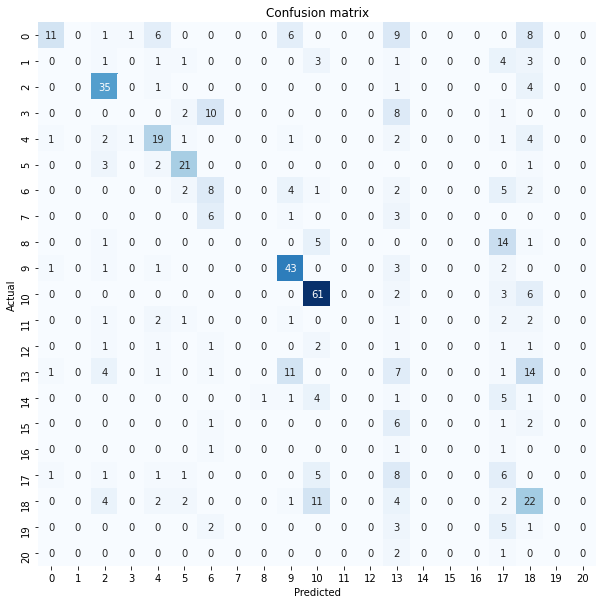


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  365.314320  | 292.646732 |   11.25   |   5.36   
Validation loss decreased (inf --> 292.646732).  Saving model ...
   2    |  356.997376  | 300.887583 |   17.50   |   5.37   
EarlyStopping counter: 1 out of 5
   3    |  346.910244  | 269.648490 |   13.91   |   5.37   
Validation loss decreased (292.646732 --> 269.648490).  Saving model ...
   4    |  309.365177  | 234.065295 |   26.88   |   5.40   
Validation loss decreased (269.648490 --> 234.065295).  Saving model ...
   5    |  263.144205  | 212.157468 |   36.56   |   5.46   
Validation loss decreased (234.065295 --> 212.157468).  Saving model ...
   6    |  227.544054  | 208.116635 |   38.44   |   5.36   
Validation loss decreased (212.157468 --> 208.116635).  Saving model ...
   7    |  189.025676  | 197.297861 | 

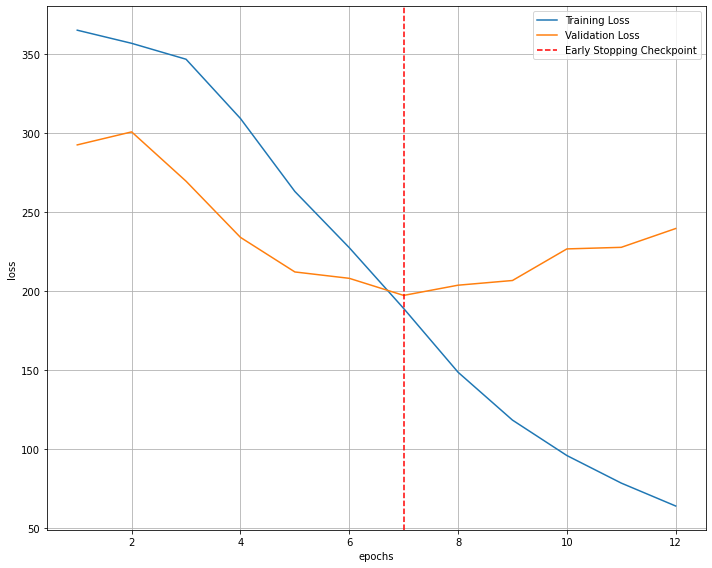

--------------- Fold:  9 ---------------------

              precision    recall  f1-score   support

           0       0.43      0.50      0.46        42
           1       1.00      0.07      0.13        14
           2       0.54      0.53      0.53        40
           3       0.15      0.14      0.15        21
           4       0.45      0.44      0.44        32
           5       0.27      0.37      0.31        27
           6       0.37      1.00      0.54        24
           7       0.00      0.00      0.00        10
           8       0.33      0.20      0.25        20
           9       0.77      0.86      0.81        51
          10       0.70      0.82      0.76        72
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         8
          13       0.22      0.23      0.22        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

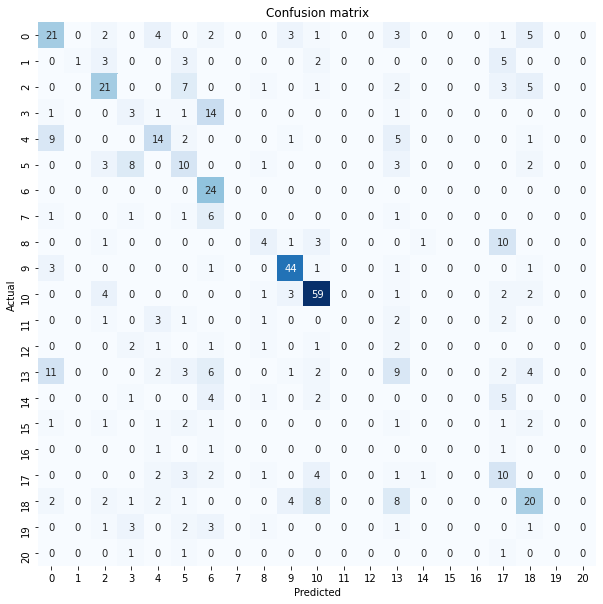


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  365.187568  | 292.280071 |   11.25   |   5.70   
Validation loss decreased (inf --> 292.280071).  Saving model ...
   2    |  347.501799  | 271.749958 |   15.47   |   5.41   
Validation loss decreased (292.280071 --> 271.749958).  Saving model ...
   3    |  310.029115  | 248.370492 |   22.92   |   5.37   
Validation loss decreased (271.749958 --> 248.370492).  Saving model ...
   4    |  259.520024  | 223.518361 |   28.54   |   5.37   
Validation loss decreased (248.370492 --> 223.518361).  Saving model ...
   5    |  206.273483  | 231.382935 |   36.82   |   5.37   
EarlyStopping counter: 1 out of 5
   6    |  166.818125  | 242.972816 |   38.54   |   5.37   
EarlyStopping counter: 2 out of 5
   7    |  134.636764  | 265.142056 |   44.06   |   5.37   
EarlyStopping cou

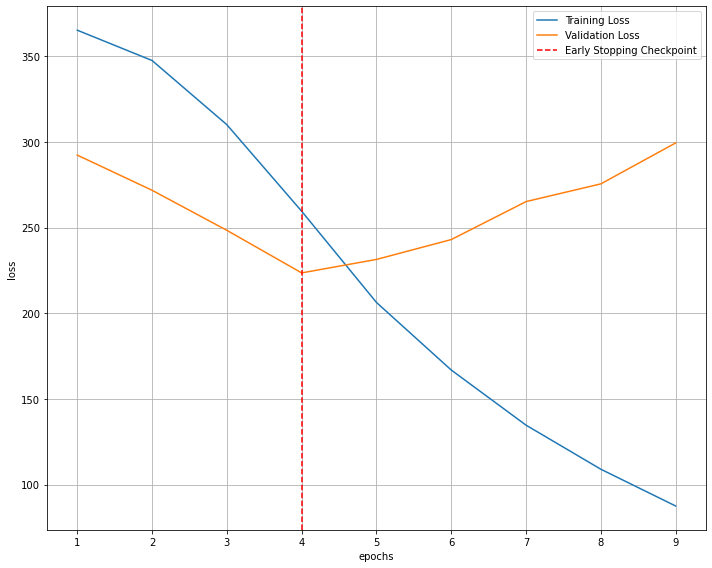

--------------- Fold: 10 ---------------------

              precision    recall  f1-score   support

           0       0.30      0.60      0.40        42
           1       0.00      0.00      0.00        15
           2       0.37      0.17      0.24        40
           3       0.00      0.00      0.00        21
           4       0.32      0.25      0.28        32
           5       0.20      0.63      0.30        27
           6       0.11      0.08      0.10        24
           7       0.00      0.00      0.00        11
           8       0.27      0.15      0.19        20
           9       0.56      0.88      0.68        50
          10       0.51      0.57      0.54        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.20      0.17      0.19        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

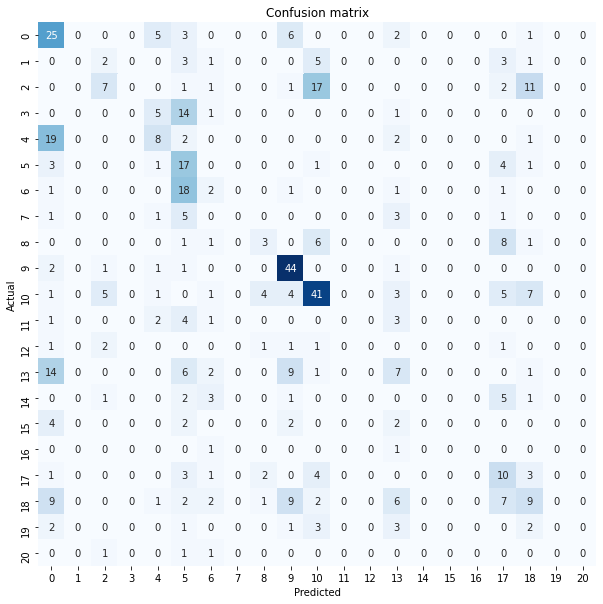

In [27]:
####### Setting up Cross-Validation #####
y=np.array(classes)
documents=np.array(documents)
kfold = StratifiedKFold(n_splits=nfold).split(documents, y)

####### Define Variables for Metrics #####
accuracys = []
scores= []
metriche = np.zeros((nfold,4,output_dim))

####### Cross-Validation Loop ############

for k, (train_ids, test_ids) in enumerate(kfold):
    
    padded_sentences_train,lenght_train = pad_text(documents[train_ids], seq_length = int(quant))
    padded_sentences_test,lenght_test = pad_text(documents[test_ids], seq_length = int(quant))
    
    encoded_sentences_train = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_train])
    encoded_sentences_test  = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_test])
    
    print("train:",encoded_sentences_train.shape,"len:",lenght_train.size, "train_y:",y[train_ids].size)
    print("test:",encoded_sentences_test.shape,"len:",lenght_test.size)
    
    
    
    train_loader, val_loader=create_data_loader(encoded_sentences_train,lenght_train,
                                                encoded_sentences_test,lenght_test,
                                                y[train_ids],y[test_ids],batch_size)
    

  ####### Instantiate model ############  
    model = ClassificationRNN(
                        pretrained_embedding=embeddings, 
                        output_dim=output_dim,
                        dropout=dropout_pc,
                        hidden_dim=hidden_dim,
                        num_layers=num_layers,
                        bidirectional=bidirectional
                        )
    
    model=model.double()

    loss_fn = nn.CrossEntropyLoss(reduction='sum').to(DEVICE)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=lr,weight_decay=0.01)
    model.to(DEVICE)
    model=train(model,optimizer,loss_fn,train_loader,val_loader,patience,n_epochs)
    
    ####### Compute Accuracy ##########
    y_pred=pytorch_predict(model,val_loader)
    
    y_true=y[test_ids]
    
    target_names=np.unique(y[train_ids])
    accuracys.append(metrics.accuracy_score(y_true, y_pred))

    ####### Compute Precision,Recall,F-Score ############
    score=precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, labels=target_names, average="weighted")
    scores.append(score[0:3])

    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    dizionario=metrics.classification_report(y_true, y_pred, target_names=target_names,output_dict=True)
    for k_d,(m_id, m_info) in enumerate(dizionario.items()):
        if k_d<output_dim:
            for j_d,key in enumerate(m_info):
                metriche[k,j_d,k_d]=m_info[key]
        else:
            break

     ## Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cbar=False,cmap=plt.cm.Blues)
    ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=target_names, 
           yticklabels=target_names, title="Confusion matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

arr = np.array(scores)


## Results Output

In [28]:
print("Overall results of the cross-validation procedure")
print()
print("Level 1")
print()

print('\nCV accuracy: %.2f +/- %.2f max: %.2f' % (np.mean(accuracys)*100, np.std(accuracys)*100,np.max(accuracys)*100))
print('\nCV precision: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,0])*100, np.std(arr[:,0])*100,np.max(arr[:,0])*100))
print('\nCV recall: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,1])*100, np.std(arr[:,1])*100,np.max(arr[:,1])*100))
print('\nCV f1: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,2])*100, np.std(arr[:,2])*100,np.max(arr[:,2])*100))

print()
print("Level 2")
print()
print(f"{'Class':^7} | {'precision':^9}{'':^6} | {'recall':^10}{'':^5} | {'f1-measure':^6}{'':^5} | {'support':^9}")
for i in range(output_dim):
    print(f"{i :^7} | {np.mean(metriche[:,0,i])*100:^5.2f}  +/-{np.std(metriche[:,0,i])*100:^6.2f} | {np.mean(metriche[:,1,i])*100:^5.2f} +/-{np.std(metriche[:,1,i])*100:^6.2f} | {np.mean(metriche[:,2,i])*100:^5.2f} +/-{np.std(metriche[:,2,i])*100:^6.2f} | {np.mean(metriche[:,3,i]):^9.2f}")

Overall results of the cross-validation procedure

Level 1


CV accuracy: 43.83 +/- 4.05 max: 47.81

CV precision: 39.33 +/- 5.14 max: 45.64

CV recall: 43.83 +/- 4.05 max: 47.81

CV f1: 39.74 +/- 4.57 max: 44.88

Level 2

 Class  | precision       |   recall        | f1-measure      |  support 
   0    | 42.92  +/-11.90  | 47.38 +/-16.58  | 42.02 +/- 7.35  |   42.00  
   1    | 23.50  +/-31.94  | 4.95  +/- 5.56  | 7.02  +/- 7.61  |   14.30  
   2    | 58.53  +/-15.42  | 62.13 +/-22.68  | 58.10 +/-17.18  |   40.30  
   3    | 27.33  +/-18.30  | 34.48 +/-23.30  | 28.28 +/-16.73  |   20.50  
   4    | 45.24  +/-11.19  | 42.99 +/-14.83  | 41.83 +/-10.49  |   32.40  
   5    | 49.65  +/-16.14  | 71.43 +/-14.13  | 57.45 +/-14.99  |   27.30  
   6    | 31.83  +/- 9.43  | 53.55 +/-25.04  | 38.44 +/-12.99  |   23.90  
   7    | 2.00   +/- 6.00  | 0.91  +/- 2.73  | 1.25  +/- 3.75  |   10.70  
   8    | 31.98  +/-26.35  | 17.83 +/-10.73  | 20.21 +/-10.44  |   20.30  
   9    | 74.91  +/-10.55  |